In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, confusion_matrix
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import json
import tf2onnx

C:\Users\drain\AppData\Local\Temp\ipykernel_21052\385346805.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
tf.random.set_seed(43)

In [3]:
data = pd.read_csv("training.csv.gz")
data.head()

,TrackP,TrackNDoFSubdetector2,BremDLLbeElectron,MuonLooseFlag,FlagSpd,SpdE,EcalDLLbeElectron,DLLmuon,RICHpFlagElectron,EcalDLLbeMuon,...,TrackNDoF,RICHpFlagMuon,RICH_DLLbeKaon,RICH_DLLbeElectron,HcalE,MuonFlag,FlagMuon,PrsE,RICH_DLLbeMuon,RICH_DLLbeProton
0,74791.156263,15.0,0.232275,1.0,1.0,3.2,-2.505719,6.604153,1.0,1.929960,...,28.0,1.0,-7.213300,-0.280200,5586.589846,1.0,1.0,10.422315,-2.081143e-07,-24.824400
1,2738.489989,15.0,-0.357748,0.0,1.0,3.2,1.864351,0.263651,1.0,-2.061959,...,32.0,1.0,-0.324317,1.707283,-0.000007,0.0,1.0,43.334935,2.771583e+00,-0.648017
2,2161.409908,17.0,-999.000000,0.0,0.0,-999.0,-999.000000,-999.000000,0.0,-999.000000,...,27.0,0.0,-999.000000,-999.000000,-999.000000,0.0,0.0,-999.000000,-9.990000e+02,-999.000000
3,15277.730490,20.0,-0.638984,0.0,1.0,3.2,-2.533918,-8.724949,1.0,-3.253981,...,36.0,1.0,-35.202221,-14.742319,4482.803707,0.0,1.0,2.194175,-3.070819e+00,-29.291519
4,7563.700195,19.0,-0.638962,0.0,1.0,3.2,-2.087146,-7.060422,1.0,-0.995816,...,33.0,1.0,25.084287,-10.272412,5107.554680,0.0,1.0,0.000015,-5.373712e+00,23.653087


### Список колонок в выборках

Здесь **Spd** обозначает Scintillating Pad Detector (сцинтилляционный детектор), **Prs** - Preshower (предшоуэрный детектор), **Ecal** - электромагнитный калориметр, **Hcal** - адронный калориметр, **Brem** обозначает следы частиц, отклоненных детектором.

- ID - идентификатор для треков (присутствует только в тестовом файле для целей отправки)
- Label - строковое значение, обозначающее типы частиц. Может принимать значения "Electron", "Muon", "Kaon", "Proton", "Pion" и "Ghost". Эта колонка отсутствует в тестовом файле.
- FlagSpd - флаг (0 или 1), если реконструированный трек проходит через Spd
- FlagPrs - флаг (0 или 1), если реконструированный трек проходит через Prs
- FlagBrem - флаг (0 или 1), если реконструированный трек проходит через Brem
- FlagEcal - флаг (0 или 1), если реконструированный трек проходит через Ecal
- FlagHcal - флаг (0 или 1), если реконструированный трек проходит через Hcal
- FlagRICH1 - флаг (0 или 1), если реконструированный трек проходит через первый детектор RICH
- FlagRICH2 - флаг (0 или 1), если реконструированный трек проходит через второй детектор RICH
- FlagMuon - флаг (0 или 1), если реконструированный трек проходит через мюонные станции (Muon)
- SpdE - энергия, связанная с треком в Spd
- PrsE - энергия, связанная с треком в Prs
- EcalE - энергия, связанная с треком в Ecal
- HcalE - энергия, связанная с треком в Hcal
- PrsDLLbeElectron - дельта логарифма правдоподобия для кандидата в частицы быть электроном, используя информацию из Prs
- BremDLLbeElectron - дельта логарифма правдоподобия для кандидата в частицы быть электроном, используя информацию из Brem
- TrackP - импульс частицы
- TrackPt - поперечный импульс частицы
- TrackNDoFSubdetector1 - число степеней свободы для подгонки трека, используя попадания в субдетектор1
- TrackQualitySubdetector1 - качество подгонки трека (chi2), используя попадания в субдетектор1
- TrackNDoFSubdetector2 - число степеней свободы для подгонки трека, используя попадания в субдетектор2
- TrackQualitySubdetector2 - качество подгонки трека (chi2), используя попадания в субдетектор2
- TrackNDoF - число степеней свободы для подгонки трека, используя попадания во все субдетекторы
- TrackQualityPerNDoF - качество подгонки трека (chi2) на степень свободы
- TrackDistanceToZ - расстояние между треком и осью z (осью пучка)
- Calo2dFitQuality - качество 2D подгонки кластеров в калориметре
- Calo3dFitQuality - качество 3D подгонки в калориметре с предположением, что частица была электроном
- EcalDLLbeElectron - дельта логарифма правдоподобия для кандидата в частицы быть электроном, используя информацию из Ecal
- EcalDLLbeMuon - дельта логарифма правдоподобия для кандидата в частицы быть мюоном, используя информацию из Ecal
- EcalShowerLongitudinalParameter - продольный параметр шауэра в Ecal
- HcalDLLbeElectron - дельта логарифма правдоподобия для кандидата в частицы быть электроном, используя информацию из Hcal
- HcalDLLbeMuon - дельта логарифма правдоподобия для кандидата в частицы быть мюоном, используя информацию из Hcal
- RICHpFlagElectron - флаг (0 или 1), если импульс больше порога для электронов, чтобы произвести свет Черенкова
- RICHpFlagProton - флаг (0 или 1), если импульс больше порога для протонов, чтобы произвести свет Черенкова
- RICHpFlagPion - флаг (0 или 1), если импульс больше порога для пионов, чтобы произвести свет Черенкова
- RICHpFlagKaon - флаг (0 или 1), если импульс больше порога для каонов, чтобы произвести свет Черенкова
- RICHpFlagMuon - флаг (0 или 1), если импульс больше порога для мюонов, чтобы произвести свет Черенкова
- RICH_DLLbeBCK - дельта логарифма правдоподобия для кандидата в частицы быть фоновым, используя информацию из RICH
- RICH_DLLbeKaon - дельта логарифма правдоподобия для кандидата в частицы быть каоном, используя информацию из RICH
- RICH_DLLbeElectron - дельта логарифма правдоподобия для кандидата в частицы быть электроном, используя информацию из RICH
- RICH_DLLbeMuon - дельта логарифма правдоподобия для кандидата в частицы быть мюоном, используя информацию из RICH
- RICH_DLLbeProton - дельта логарифма правдоподобия для кандидата в частицы быть протоном, используя информацию из RICH
- MuonFlag - мюонный флаг (является ли этот трек мюоном), который определяется по мюонным станциям
- MuonLooseFlag - мюонный флаг (является ли этот трек мюоном), который определяется по мюонным станциям с использованием более слабых критериев
- MuonLLbeBCK - логарифм правдоподобия для кандидата в частицы не быть мюоном, используя информацию из мюонных станций
- MuonLLbeMuon - логарифм правдоподобия для кандидата в частицы быть мюоном, используя информацию из мюонных станций
- DLLelectron - дельта логарифма правдоподобия для кандидата в частицы быть электроном, используя информацию из всех субдетекторов
- DLLmuon - дельта логарифма правдоподобия для кандидата в частицы быть мюоном, используя информацию из всех субдетекторов
- DLLkaon - дельта логарифма правдоподобия для кандидата в частицы быть каоном, используя информацию из всех субдетекторов
- DLLproton - дельта логарифма правдоподобия для кандидата в частицы быть протоном, используя информацию из всех субдетекторов
- GhostProbability - вероятность для кандидата в частицы быть призрачным треком. Эта переменная является выходом классификационной модели, используемой в алгоритме трекинга.

Дельта логарифма правдоподобия в описаниях признаков означает разницу между логарифмом правдоподобия для гипотезы массы, что данный трек создан некоторой частицей (например, электроном) и логарифмом правдоподобия для гипотезы массы, что данный трек создан пионом (то есть DLLpion = 0, и поэтому у нас нет этих колонок). Это сделано потому, что большинство треков (~80%) оставлены пионами, и на практике нам действительно нужно различать другие частицы от пионов. Иными словами, нулевая гипотеза заключается в том, что частица является пионом.

In [4]:
x = np.asarray(data.loc[:, data.columns != 'Label'], dtype=np.float32) # Извлечение признаков
le = preprocessing.LabelEncoder() # Инициализация и обучение кодировщика мето
le.fit(data.Label)
y = le.transform(data.Label).astype(np.float32) # Преобразование меток в числа и создание вектора меток
labels = np.array(le.classes_, dtype=str) # сохранение массива уникальных меток

In [5]:
# разделение данных на обучающую и тестовую выборки
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=43, stratify=y) 
x_train.shape, y_train.shape

((840000, 49), (840000,))

In [7]:
# баланс классов
class_counts = data['Label'].value_counts() 
class_counts

Label
Muon        200000
Ghost       200000
Pion        200000
Proton      200000
Kaon        200000
Electron    200000
Name: count, dtype: int64

In [8]:
INPUT_DIM  = x_train.shape[1] # Определение размера входного слоя - количество признаков. Каждый входной нейрон соответствует одному признаку в данных.
HIDDEN_DIM = 200 # количество нейронов в скрытом слое
OUTPUT_DIM = len(labels) # количество меток - количество выходов. Каждый выходной нейрон соответствует одной уникальной метке, и задачей сети является предсказание вероятности каждой метки для входных данных.

In [9]:
def create_model(input_dim, hidden_dim, output_dim): # создание модели нейросети
    
    model = tf.keras.Sequential([ # Создаёт последовательную модель, где слои добавляются один за другим.
        tf.keras.layers.Dense(hidden_dim, activation='relu', input_shape=(input_dim,)), #Dense - полносвязный слой нейросети, т.е. каждый нейрон предыдущего слоя связан с каждым нейроном следующего слоя
      
        tf.keras.layers.BatchNormalization(), # Нормализует активации предыдущего слоя, ускоряя обучение и стабилизируя процесс.
        tf.keras.layers.Dropout(0.3), #Обнуляет 30% весов случайным образом в процессе обучения, что помогает предотвратить переобучение.
        
        tf.keras.layers.Dense(hidden_dim, activation='relu'), # второй скрытый слой
        tf.keras.layers.BatchNormalization(), # второй слой нормализации данных
        tf.keras.layers.Dropout(0.3), # второй слой регуляризации
        
        tf.keras.layers.Dense(hidden_dim // 2, activation='relu'), # третий скрытый слой и тп
        tf.keras.layers.BatchNormalization(), 
        tf.keras.layers.Dropout(0.3), 
        
        tf.keras.layers.Dense(output_dim, activation='softmax', name='output') # выходной слой
        # Использует функцию активации Softmax, что типично для многоклассовой классификации. Softmax преобразует выходные данные в вероятности принадлежности к каждому из классов.
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # компиляция модели - оптимизатор Adam - алгоритм оптимизации, learning_rate=0.001 - скорость обучения
                  loss='categorical_crossentropy', # функция потерь - кросс-энтропия
                  metrics=['AUC', 'accuracy']) # метрики - площадь под ROC-кривой и точность
    
    return model


In [11]:
model = create_model(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM) # создание модели
model.summary() # вывод информации о модели

d:\HSE\OAD\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │        10,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,906 (284.79 KB)

 Trainable params: 71,906 (280.88 KB)

 Non-trainable params: 1,000 (3.91 KB)

In [13]:
learning_rate = 1e-5 # скорость обучения влияет на скорость сходимости модели и качество обучения
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy']) 
# компиляция модели с новой скоростью обучения

In [49]:
history = model.fit(x_train, tf.keras.utils.to_categorical(y_train, num_classes=len(labels)),
        #Преобразует вектор меток классов y_train в двумерный массив меток в формате one-hot. 
        # В one-hot кодировке каждая метка представлена в виде массива, где один элемент равен 1, 
        # а все остальные равны 0. Количество классов (num_classes) указывает размерность каждого one-hot вектора.
        epochs=10, batch_size=100, 
        validation_data=(x_test, tf.keras.utils.to_categorical(y_test, num_classes=len(labels))))

Epoch 1/10
8400/8400 ━━━━━━━━━━━━━━━━━━━━ 54s 6ms/step - accuracy: 0.6589 - loss: 0.8357 - val_accuracy: 0.6884 - val_loss: 0.7655
Epoch 2/10
8400/8400 ━━━━━━━━━━━━━━━━━━━━ 56s 7ms/step - accuracy: 0.6597 - loss: 0.8331 - val_accuracy: 0.6884 - val_loss: 0.7638
Epoch 3/10
8400/8400 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - accuracy: 0.6607 - loss: 0.8313 - val_accuracy: 0.6895 - val_loss: 0.7617
Epoch 4/10
8400/8400 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - accuracy: 0.6629 - loss: 0.8279 - val_accuracy: 0.6896 - val_loss: 0.7603
Epoch 5/10
8400/8400 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - accuracy: 0.6638 - loss: 0.8259 - val_accuracy: 0.6908 - val_loss: 0.7575
Epoch 6/10
8400/8400 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - accuracy: 0.6643 - loss: 0.8248 - val_accuracy: 0.6921 - val_loss: 0.7557
Epoch 7/10
8400/8400 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - accuracy: 0.6656 - loss: 0.8215 - val_accuracy: 0.6930 - val_loss: 0.7535
Epoch 8/10
8400/8400 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - accuracy: 0.6658 - loss: 0

In [50]:
spec = (tf.TensorSpec((None, INPUT_DIM), tf.float32, name="input"),) # Спецификация входных данныzx
output_path = "particles.onnx" # Указывает путь, по которому будет сохранён файл модели в формате ONNX.
model.output_names = ['output'] # Задаёт имя выходного тензора модели
model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, output_path=output_path) # Функция из библиотеки tf2onnx, которая конвертирует модель Keras в формат ONNX.

In [48]:
def plot_roc_curve(y_true, y_pred_scores, class_labels, save_fig=True):
    # y_true - истинные метки классов, y_pred_scores - предсказанные вероятности классов, class_labels - метки классов
    # Инициализация словарей для хранения значений FPR, TPR и AUC
    false_positive_rate, true_positive_rate, roc_aucs = {}, {}, {}
    
    # Создание фигуры для отображения
    plt.figure(figsize=(8, 6))
    sns.set(style="whitegrid")  # Применение стиля seaborn для фигуры
    
    # Построение ROC-кривых для каждого класса
    for idx, label in enumerate(class_labels):
        # Вычисление значений FPR и TPR
        false_positive_rate[label], true_positive_rate[label], _ = roc_curve(y_true[:, idx], y_pred_scores[:, idx])
        # Вычисление значения AUC
        roc_aucs[label] = auc(false_positive_rate[label], true_positive_rate[label])
        plt.plot(false_positive_rate[label], true_positive_rate[label], label=f'Class {label} (AUC = {roc_aucs[label]:.3f})')
    
    # Добавление диагональной линии
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    
    # Настройка осей и легенды
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    
    # Сохранение графика, если необходимо
    if save_fig:
        plt.savefig('roc.png')
    
    plt.show()
    plt.close()

    return roc_aucs

In [25]:
def plot_training_history(history):
    # Устанавливаем стиль seaborn
    sns.set(style="whitegrid")
    # Создаем фигуру для графиков
    plt.figure(figsize=(10, 8))
    # Построение графика потерь на обучающем наборе
    plt.plot(history.history['loss'], label='Train Loss', color='blue')
    # Построение графика потерь на валидационном наборе
    plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig('train.png')
    plt.show()
    plt.close()

In [26]:
def plot_confusion_matrix(y_true, y_pred, labels):
    # Вычисление матрицы ошибок
    cm = confusion_matrix(y_true, y_pred)
    # Настройка стиля seaborn
    sns.set(style="whitegrid")
    # Создание фигуры с заданными размерами
    plt.figure(figsize=(10, 8))
    # Создание тепловой карты для визуализации матрицы ошибок с использованием цветовой схемы 'viridis'
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', cbar=True, xticklabels=labels, yticklabels=labels)
    # Улучшение меток: смещение для полного отображения каждой метки
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.savefig('confusion.png')
    plt.show()
    plt.close()


In [27]:
def save_metrics_to_json(metrics, filename='particles.json'):
    data = {"test_auc": metrics}
    with open(filename, 'w') as json_file:
        json.dump(data, json_file, indent=4)

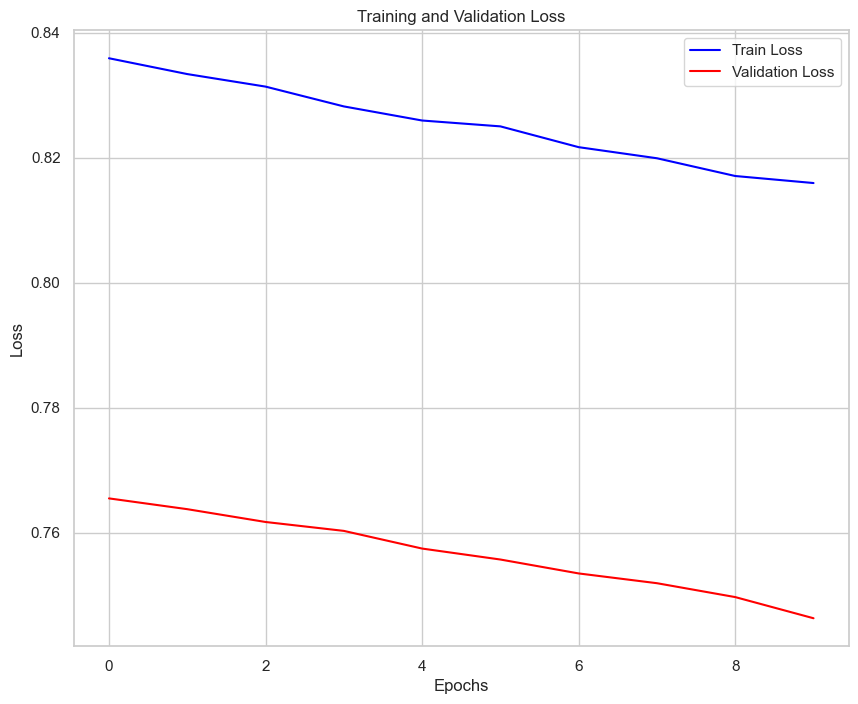

In [51]:
plot_training_history(history)

In [52]:
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=len(labels)) # Преобразование меток в формат one-hot
y_score = model.predict(x_test) # Предсказание вероятностей классов для тестовых данных
y_pred = np.argmax(y_score, axis=1) # Предсказание меток классов для тестовых данных

11250/11250 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step


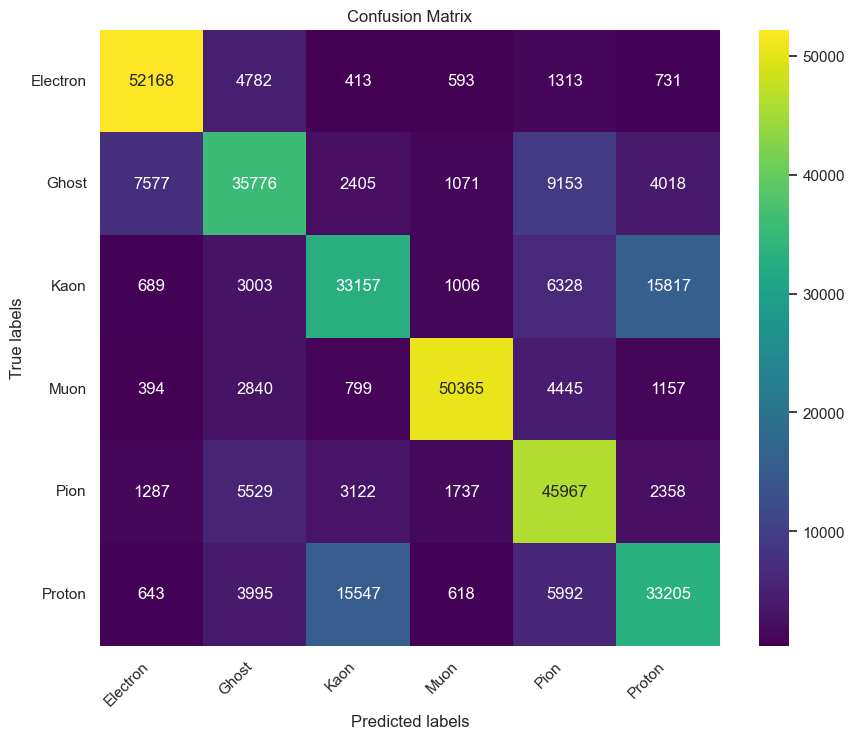

In [53]:
plot_confusion_matrix(y_test, y_pred, labels)

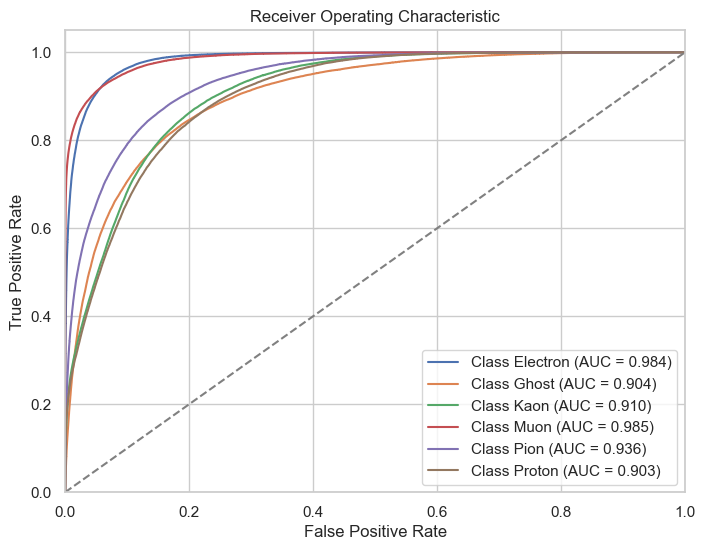

In [54]:
roc_auc = plot_roc_curve(y_test_cat, y_score, labels)

In [55]:
save_metrics_to_json(roc_auc)